In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

INFO=====>voc dataset init finished  ! !
INFO===>eval dataset has 750 imgs
INFO===>success frozen BN
INFO===>success frozen backbone stage1
===>success loading model


KeyboardInterrupt: 

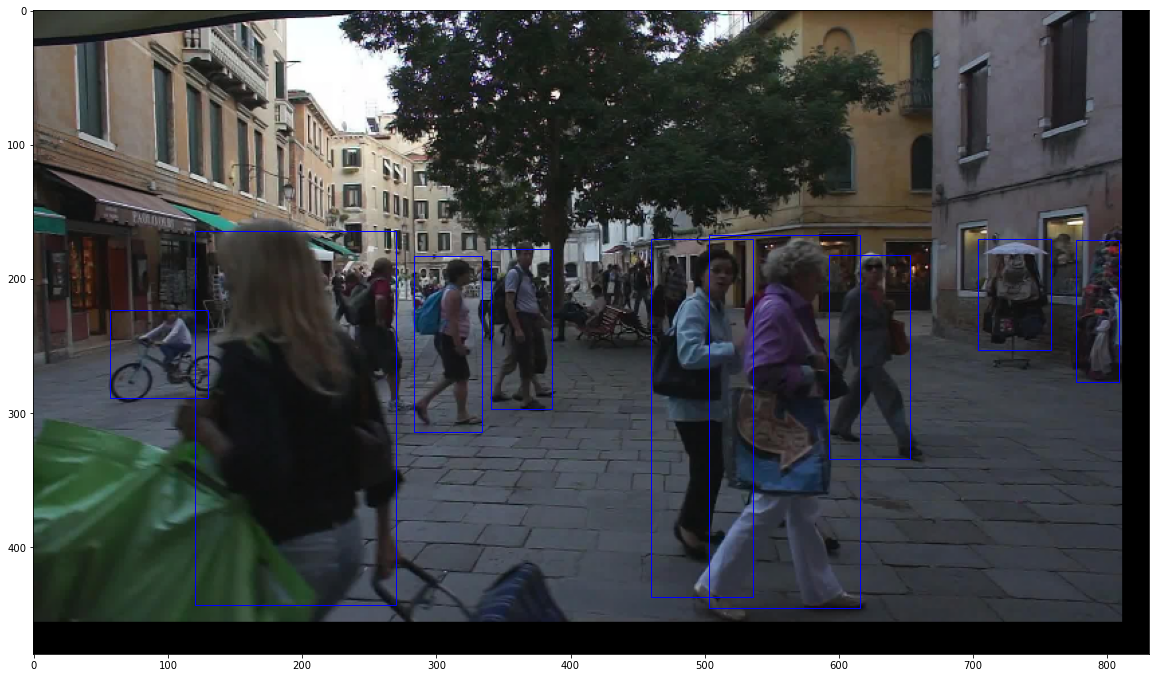

In [4]:
import torch
import numpy as np
import cv2
from FCOS_Pytorch.model.fcos import FCOSDetector
#from demo import convertSyncBNtoBN
from FCOS_Pytorch.dataloader.VOC_dataset import VOCDataset
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sort import *
%matplotlib inline

eval_dataset=VOCDataset("./MOT17-02-DPM",resize_size=[500,812],split='viz')

print("INFO===>eval dataset has %d imgs"%len(eval_dataset))
eval_loader=torch.utils.data.DataLoader(eval_dataset,batch_size=1,shuffle=False,collate_fn=eval_dataset.collate_fn)

model=FCOSDetector(mode="inference")
model.load_state_dict(torch.load("./FCOS_Pytorch/model/model_20epochs.pth",map_location=torch.device('cpu')))
model=model.cuda().eval()
print("===>success loading model")

gt_boxes=[]
gt_classes=[]
pred_boxes=[]
pred_classes=[]
pred_scores=[]
num=0

time_list = []

mot_tracker = Sort()

for img in eval_loader:
    arr_list = []
    
    start_t = time.time()
    with torch.no_grad():
        out=model(img.cuda())
    end_t = time.time()
    cost_t=1000*(end_t-start_t)
    
    with torch.no_grad():
        out=model(img.cuda())
        end_t=time.time()
        
    scores,classes,boxes=out

    boxes=boxes[0].cpu().numpy().tolist()
    classes=classes[0].cpu().numpy().tolist()
    scores=scores[0].cpu().numpy().tolist()
    
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img.cpu().numpy()[0]
    img[0] = img[0]*std[0] + mean[0]
    img[1] = img[1]*std[1] + mean[1]
    img[2] = img[2]*std[2] + mean[2]

    img = img.transpose(1,2,0)

    
    time_list.append(cost_t)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.imshow(img)
    
    
    class_list = []
    score_list = []
    for i,box in enumerate(boxes):            
        
        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))

        w1 = pt2[0] - pt1[0]
        h1 = pt2[1] - pt1[1]

        arr_list.append([box[0],box[1], box[2], box[3]])
    
    arr_list = np.array(arr_list)                   
    #plt.figtext(0.0, 0.01, class_list)
    
    track_bbs_ids = mot_tracker.update(np.array(arr_list))
    
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        w = int(ele[2])
        h = int(ele[3])
        track_label = str(int(ele[4])) 
        
        w2 = w-x
        h2 = h-y
        
        # Create a Rectangle patchi
        rect = patches.Rectangle((x,y),w2,h2,linewidth=1,edgecolor='blue',facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    plt.savefig('./SORT_test/'+str(num))
    plt.close(fig)
    
    
    num +=1